In [1]:
# Common imports
import pandas as pd
import numpy as np
import os
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images",)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Load data

In [2]:
def load_data():
    data = pd.read_csv('spill_incidents_sample.csv')
    return data

#### Create target variable
- The dataset has a column “recovered”. Recovered can be greater than 0(YES) or equals to 0 (NO).

In [3]:
def transform_target(df):
    df['recovered'] = df['recovered'].apply(lambda x:'YES' if x >0 else 'NO')
    return df

data = load_data()
data = transform_target(data)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.to_csv('spill_incidents_sample_with_target.csv', index=False)


#### Data overview

In [4]:
data.tail(3)

spill_number                              program_facility_name  \
187666       9707739                          KIKARI DENTAL RT 30 AGWAY   
187667       1209420                                           POLE TOP   
187668        900797  CUMBERLAND FARMS #3141  RT 9 @ BOGHT RD LOUDON RD   

                              street_1  \
187666                4340 RT 30 NORTH   
187667                  29 QUARRY LANE   
187668  1093 LOUDON RD RT 9 @ BOGHT RD   

                                       street_2        locality       county  \
187666                                      NaN       AMSTERDAM   Montgomery   
187667                                      NaN         BEDFORD  Westchester   
187668  CUMBERLAND FARMS # 3141  1093 LOUDON RD  COHOES COLONIE       Albany   

       zip_code  swis_code  dec_region  spill_date received_date  \
187666      NaN       2920           4  1997-09-30    1997-09-30   
187667      NaN       6020           3  2012-11-06    2012-11-06   
187668      NaN        126           4  2009-04-21    2009-04-21   

       contributing_factor waterbody                                  source  \
187666       Tank Overfill       NaN                              Tank Truck   
187667               Storm       NaN                             Transformer   
187668               Other       NaN  Gasoline Station or other PBS Facility   

        close_date     material_name material_family  quantity    units  \
187666  1997-10-03       #2 fuel oil       Petroleum       0.0  Gallons   
187667  2012-11-09  dielectric fluid       Petroleum      10.0  Gallons   
187668  2009-05-08   other  -  WATER           Other       0.0  Gallons   

       recovered  
187666        NO  
187667        NO  
187668        NO

In [5]:
data.dtypes

spill_number               int64
program_facility_name     object
street_1                  object
street_2                  object
locality                  object
county                    object
zip_code                  object
swis_code                  int64
dec_region                 int64
spill_date                object
received_date             object
contributing_factor       object
waterbody                 object
source                    object
close_date                object
material_name             object
material_family           object
quantity                 float64
units                     object
recovered                 object
dtype: object

In [6]:
data.describe()

spill_number      swis_code     dec_region      quantity
count  1.876690e+05  187669.000000  187669.000000  1.876690e+05
mean   4.442654e+06    3478.814391       3.992956  5.350332e+05
std    4.208655e+06    1717.484381       2.593400  2.308367e+08
min    1.000000e+00     100.000000       1.000000  0.000000e+00
25%    7.069440e+05    2401.000000       2.000000  0.000000e+00
50%    1.511169e+06    3400.000000       3.000000  0.000000e+00
75%    9.211040e+06    5200.000000       6.000000  5.000000e+00
max    9.975754e+06    9500.000000       9.000000  1.000000e+11

In [7]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Number of Columns','Number of Rows', 'File Size']
x.add_row([data.shape[1], data.shape[0], os.path.getsize('spill_incidents_sample.csv')])
print(x)

+-------------------+----------------+-----------+
| Number of Columns | Number of Rows | File Size |
+-------------------+----------------+-----------+
|         20        |     187669     |  35570195 |
+-------------------+----------------+-----------+


#### Column Type Counts

In [8]:
from dateutil.parser import parse

def check_is_categorical(df, col):
    unique_samples = len(df[col].unique())
    total_samples = df[col].shape[0]
    pct_diff = round((total_samples - unique_samples) / total_samples * 100,2)
#     print(pct_diff)
    if pct_diff <= 94:
        return [False,col] # not categorical
    else:
        return [True, col]  # categorical
    
def check_is_date(df, col):
    string = df[col].dropna().unique()[0]
    try: 
        parse(string, fuzzy=False)
        return [True, col]

    except ValueError:
        return [False, col]
    
    
def get_column_type(df):
    categorical_features = []
    numeric = list(data.select_dtypes(['int64','float64']).columns)
    types = {'Numeric':[len(data.select_dtypes(['int64','float64']).count()), numeric],\
             'Text':[0,[]],'Categorical':[0,[]], 'Date':[0,[]]}

    for col in df.columns:
        sample = df[col].dropna().unique()[0]
        if isinstance(sample, str):
            res = check_is_date(df, col)
            if res[0]:
                types['Date'][0] +=1
                types['Date'][1].append(col)
            else:
                res = check_is_categorical(df, col)
                if res[0]:
                    types['Categorical'][0] += 1
                    types['Categorical'][1].append(col)
                    categorical_features.append(col)
                else:
                    types['Text'][0] += 1
                    types['Text'][1].append(col)
    return types, numeric, categorical_features


x = PrettyTable()

column_type_count, numerical_features, categorical_features = get_column_type(data)
x.field_names = ['Feature type', 'Count', 'Feature Name']
x._max_width = {"Feature type":3, "Count":3,"Feature Name":90}
for k,v in column_type_count.items():
    x.add_row([k,v[0],v[1]])
print(x)

+--------------+-------+--------------------------------------------------------------------------------------------+
| Feature type | Count |                                        Feature Name                                        |
+--------------+-------+--------------------------------------------------------------------------------------------+
|   Numeric    |   4   |                  ['spill_number', 'swis_code', 'dec_region', 'quantity']                   |
|     Text     |   3   |                     ['program_facility_name', 'street_1', 'street_2']                      |
| Categorical  |   10  |      ['locality', 'county', 'zip_code', 'contributing_factor', 'waterbody', 'source',      |
|              |       |                 'material_name', 'material_family', 'units', 'recovered']                  |
|     Date     |   3   |                       ['spill_date', 'received_date', 'close_date']                        |
+--------------+-------+--------------------------------

# EDA

### Country wise trend of incident

In [9]:
import plotly.express as px
import plotly.graph_objects as go

eda_data = data.copy()
eda_data[["year", "month", "day"]] = eda_data["received_date"].str.split("-", expand = True)
# eda_data = eda_data[:1000]
eda_data[["received_year", "received_month", "received_day"]] = eda_data["received_date"].str.split("-", expand = True)
eda_data.received_date = pd.to_datetime(eda_data.received_date)
eda_data = eda_data.sort_values(by='received_date')
eda_data_date = eda_data[['received_year', 'county','spill_number']]
eda_data_date = eda_data_date.rename(columns={'spill_number':'count'})
eda_data_date = eda_data_date.groupby(['received_year', 'county']).count()
eda_data_date = eda_data_date.reset_index()
eda_data_date.to_csv('count.csv', index=False)
eda_data_date.received_year = pd.to_datetime(eda_data_date.received_year)
eda_data_date = eda_data_date.sort_values(by='received_year')
# eda_data.to_csv('count.csv', index=False)

fig = px.bar(eda_data_date, x="received_year", y="count", color="county", title="country-vs-received_date overtime")
fig.write_html('{}/{}.html'.format('images/', 'country-vs-received_date overtime'))
fig.show()

##### 1. The spill incidents started increasing post 1986
##### 2. Larger the country bar height, more is the count of spill incidents occured in that country

#### Country Distribution

In [10]:
fig = px.bar(eda_data_date, x="county", y="count", title="Country Distribution")
fig.write_html('{}/{}.html'.format('images/', 'Country Distribution'))
fig.show()

#### Country vs Target

In [11]:
eda_county = data.copy()
eda_county = eda_county.groupby(['county','recovered']).count().reset_index()
eda_county = eda_county[['county','recovered', 'spill_number']]
eda_county = eda_county.rename(columns={'spill_number':'count'})
fig = px.bar(eda_county, x="county", y="count", color="recovered", title="recovered by country")
fig.write_html('{}/{}.html'.format('images/', 'recovered by country'))
fig.show()

##### Above plot shows count analysis of recovered cases in respective countries

### program_facility_name distribution

In [12]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

eda_data_facility = data.copy()

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
eda_data['program_facility_name'] = eda_data['program_facility_name'].astype(str)
eda_data['program_facility_name'] = eda_data['program_facility_name'].fillna('Nan')
tag_dtm = vectorizer.fit_transform(eda_data['program_facility_name'])
tags = vectorizer.get_feature_names()
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

#### Most frequent words in `program_facility_name`

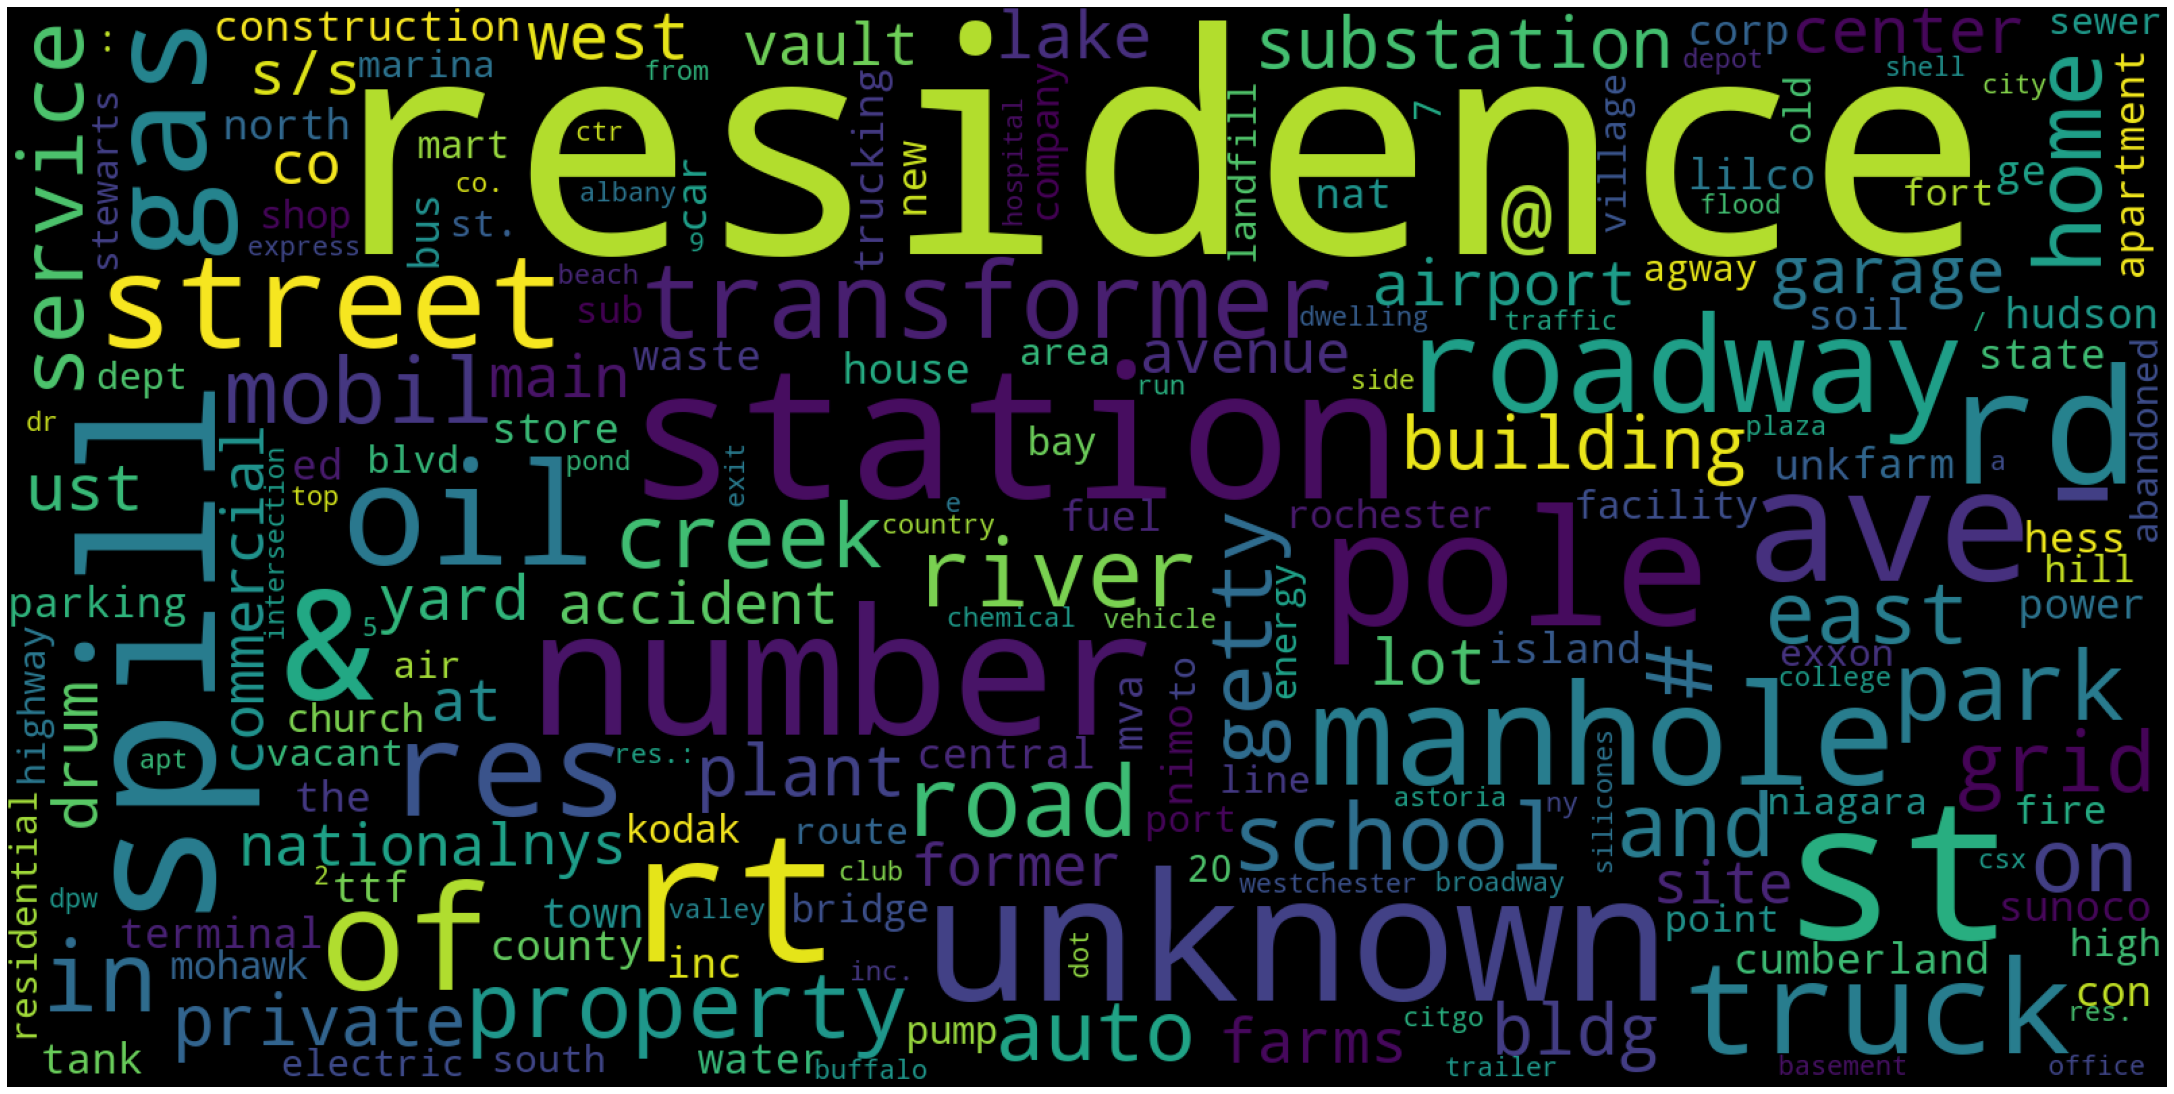

In [13]:
# Ploting word cloud
# start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()


##### 1. Most frequent word is `residence`

In [14]:
eda_data_facility = eda_data[['spill_number', 'program_facility_name', 'recovered']]
eda_data_facility = eda_data_facility.groupby(['program_facility_name', 'recovered']).count().reset_index()
eda_data_facility = eda_data_facility.rename(columns={'spill_number':'count'})
eda_data_facility = eda_data_facility.sort_values(by='count', ascending=False).head(10)

fig = px.bar(eda_data_facility, x="program_facility_name", y="count", color="recovered", title="recovered vs top 10 most imp words in program_facility_name")
fig.write_html('{}/{}.html'.format('images/', 'recovered vs top 10 most imp words in program_facility_name'))
fig.show()

### Quantity spilled and recovered EDA

In [15]:
eda_data_quantity = eda_data[['spill_number', 'quantity','recovered']]
eda_data_quantity_group = eda_data_quantity.groupby(['quantity','recovered']).count().reset_index()
eda_data_quantity_group = eda_data_quantity_group.rename(columns={'spill_number':'count'})
eda_data_quantity_plot = eda_data_quantity_group.sort_values(by='count', ascending=True).head(70)

fig = px.bar(eda_data_quantity_plot, x="quantity", y="count", color="recovered", title="quantity spilled by recovered")
fig.write_html('{}/{}.html'.format('images/', 'quantity by recovered'))
fig.show()

#### Quantity Distribution

In [16]:
eda_data_quantity_dist = eda_data_quantity[['spill_number', 'quantity']]
eda_data_quantity_dist = eda_data_quantity_dist.groupby('quantity').count().reset_index()
eda_data_quantity_dist['quantity'] = eda_data_quantity_dist['quantity'].apply("{0:.5f}".format)
fig = px.bar(eda_data_quantity_dist, x="quantity", y="spill_number",color='quantity', title="Quantity Distribution")
fig.write_html('{}/{}.html'.format('images/', 'Quantity Distribution'))
fig.show()

In [17]:
eda_data['quantity'].isna().sum()

0

In [18]:
from scipy import stats

quant = eda_data['quantity'].describe().apply("{0:.5f}".format).to_dict()
quant['count'] = eda_data['quantity'].shape[0]
quant['Misssing Values'] = str(eda_data['quantity'].isna().sum()) +' ('+ str(eda_data['quantity'].isna().sum()/eda_data['quantity'].shape[0] * 100) + '%)'
quant['Unique values'] = str(len(eda_data['quantity'].unique())) + ' (' + str(round(len(eda_data['quantity'].unique())/eda_data.shape[0] * 100, 2)) + '%)'
quant['Zero count'] = str(len(eda_data[eda_data['quantity'] == 0])) + ' (' + str(round(len(eda_data[eda_data['quantity'] == 0]) / eda_data['quantity'].shape[0] * 100, 2)) + '%)'
quant['Outliers (3 std)'] = eda_data['quantity'].shape[0] - np.count_nonzero(np.abs(stats.zscore(eda_data['quantity'])) < 3)
quant['Distribution'] = 'Skewed'
x = PrettyTable()

x.field_names = ['Atrribute', 'Value']
for k,v in quant.items():
    x.add_row([k, v])
print(x)

+------------------+--------------------+
|    Atrribute     |       Value        |
+------------------+--------------------+
|      count       |       187669       |
|       mean       |    535033.23437    |
|       std        |  230836706.54689   |
|       min        |      0.00000       |
|       25%        |      0.00000       |
|       50%        |      0.00000       |
|       75%        |      5.00000       |
|       max        | 100000000000.00000 |
| Misssing Values  |      0 (0.0%)      |
|  Unique values   |    918 (0.49%)     |
|    Zero count    |  100248 (53.42%)   |
| Outliers (3 std) |         1          |
|   Distribution   |       Skewed       |
+------------------+--------------------+


### Visualize spill locations and material

In [19]:
eda_data = data.copy()
spill_incidents_locality = eda_data['locality'].value_counts()
top_20_spill_localities = spill_incidents_locality[:20]
materail_fam = eda_data['material_family'].value_counts()

<AxesSubplot:title={'center':'Material Families'}, xlabel='count', ylabel='material_family'>

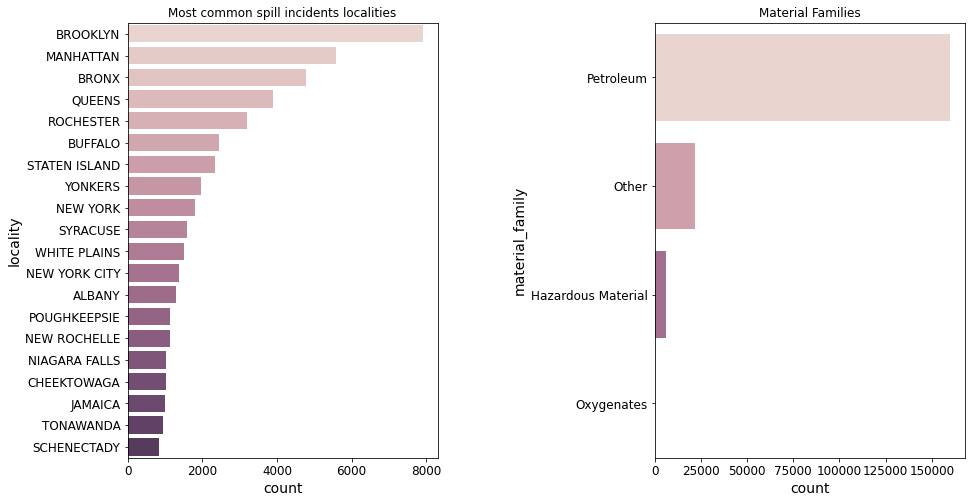

In [20]:
f, axes = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
p1 = sns.cubehelix_palette(24)
p2 = sns.cubehelix_palette(5)

plt.subplots_adjust(wspace=.7)
axes[0].set_title("Most common spill incidents localities")
sns.countplot(y="locality", data=eda_data, order=top_20_spill_localities.index, palette=p1, ax=axes[0])
axes[1].set_title("Material Families")
sns.countplot(y="material_family", data=eda_data, order=materail_fam.index, palette=p2, ax=axes[1])

###  Cross tables using the crosstab function available within Pandas.We can use this function to help get a high level view of the data similar to pivot tables in Excel.
#### Source Vs contributing factor

In [21]:
source_vs_contribution_df = pd.crosstab(eda_data['source'], eda_data['contributing_factor'],margins=True)
source_vs_contribution = source_vs_contribution_df.drop('Missing Code in Old Data - Must be fixed',1).copy()
source_vs_contribution

contributing_factor                       Abandoned Drums  Deliberate  \
source                                                                  
Chemical Bulk Storage Facility                          0           0   
Commercial Vehicle                                     29         337   
Commercial/Industrial                                 596        3070   
Gasoline Station or other PBS Facility                 45         328   
Institutional, Educational, Gov., Other               227         592   
Major Facility (MOSF) > 400,000 gal                     4          15   
Missing Code in Old Data - Must be fixed                0           2   
Non Major Facility > 1,100 gal                          8          33   
Passenger Vehicle                                       8         347   
Private Dwelling                                      268        1956   
Railroad Car                                            4           8   
Tank Truck                                              3          59   
Transformer                                             0           1   
Unknown                                              2066        1222   
Vessel                                                  9          77   
All                                                  3267        8047   

contributing_factor                       Equipment Failure  Housekeeping  \
source                                                                      
Chemical Bulk Storage Facility                            5             0   
Commercial Vehicle                                    11394           138   
Commercial/Industrial                                 21596          3008   
Gasoline Station or other PBS Facility                 3584           992   
Institutional, Educational, Gov., Other                5298           611   
Major Facility (MOSF) > 400,000 gal                    1042            48   
Missing Code in Old Data - Must be fixed                  3             3   
Non Major Facility > 1,100 gal                          359           153   
Passenger Vehicle                                      1462           103   
Private Dwelling                                      16328           939   
Railroad Car                                            492            12   
Tank Truck                                             1688            28   
Transformer                                            1903             1   
Unknown                                                1061           111   
Vessel                                                  480            20   
All                                                   66695          6167   

contributing_factor                       Human Error  Other  Storm  \
source                                                                
Chemical Bulk Storage Facility                      2      3      0   
Commercial Vehicle                               1303   1110      6   
Commercial/Industrial                            3514   6598    440   
Gasoline Station or other PBS Facility           1533   2428      4   
Institutional, Educational, Gov., Other          1036   2359     55   
Major Facility (MOSF) > 400,000 gal               246    311      7   
Missing Code in Old Data - Must be fixed            4      6      0   
Non Major Facility > 1,100 gal                    129    163      4   
Passenger Vehicle                                 305    428      4   
Private Dwelling                                 2925   3981   1074   
Railroad Car                                       38    117      4   
Tank Truck                                        959    321      1   
Transformer                                        31     69    700   
Unknown                                           237   1251     38   
Vessel                                            183    589     15   
All                                             12445  19734   2352   

contributing_factor

In [22]:
# eliminate 'All' row/col
source_vs_contribution_df = source_vs_contribution.iloc[0:15,0:13].copy()

<AxesSubplot:title={'center':'Sources of leaks and their causes'}, xlabel='contributing_factor', ylabel='source'>

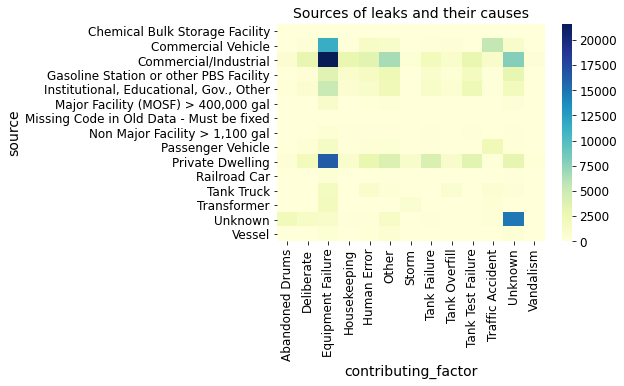

In [23]:
plt.title('Sources of leaks and their causes', fontsize=14)
sns.heatmap(source_vs_contribution_df, cmap='YlGnBu')

### Data completeness

In [24]:
def calc_data_nullity(df):
    df_nullity = df.isnull()
    missing_values_sum = df_nullity.sum()
    missing_values_percent = df_nullity.mean() * 100
    return missing_values_sum, missing_values_percent

missing_values_sum, missing_values_percent = calc_data_nullity(data)


#### Total Missing Values

In [25]:
x = PrettyTable()
print('Total Missing Values')
x.field_names = ['Column', 'Missing values Count']      
for k,v in missing_values_sum.to_dict().items():
    x.add_row([k,v])
print(x)              

Total Missing Values
+-----------------------+----------------------+
|         Column        | Missing values Count |
+-----------------------+----------------------+
|      spill_number     |          0           |
| program_facility_name |          3           |
|        street_1       |          53          |
|        street_2       |        172775        |
|        locality       |         389          |
|         county        |          0           |
|        zip_code       |        171173        |
|       swis_code       |          0           |
|       dec_region      |          0           |
|       spill_date      |          57          |
|     received_date     |          0           |
|  contributing_factor  |          0           |
|       waterbody       |        170995        |
|         source        |          0           |
|       close_date      |         4302         |
|     material_name     |          0           |
|    material_family    |          0           |

#### Percentage of Missing Values

In [26]:
x = PrettyTable()
print('Total Missing Values')
x.field_names = ['Column', 'Missing values Percentage']      
for k,v in missing_values_percent.to_dict().items():
    x.add_row([k,round(v,2)])
print(x)              

Total Missing Values
+-----------------------+---------------------------+
|         Column        | Missing values Percentage |
+-----------------------+---------------------------+
|      spill_number     |            0.0            |
| program_facility_name |            0.0            |
|        street_1       |            0.03           |
|        street_2       |           92.06           |
|        locality       |            0.21           |
|         county        |            0.0            |
|        zip_code       |           91.21           |
|       swis_code       |            0.0            |
|       dec_region      |            0.0            |
|       spill_date      |            0.03           |
|     received_date     |            0.0            |
|  contributing_factor  |            0.0            |
|       waterbody       |           91.12           |
|         source        |            0.0            |
|       close_date      |            2.29           |
|     m

- Columns **`street_2, zip_code, waterbody`** have the highest number of missing values
- Since more than 90% values are missing, its better to drop these columns

#### Visualize missingness

<AxesSubplot:>

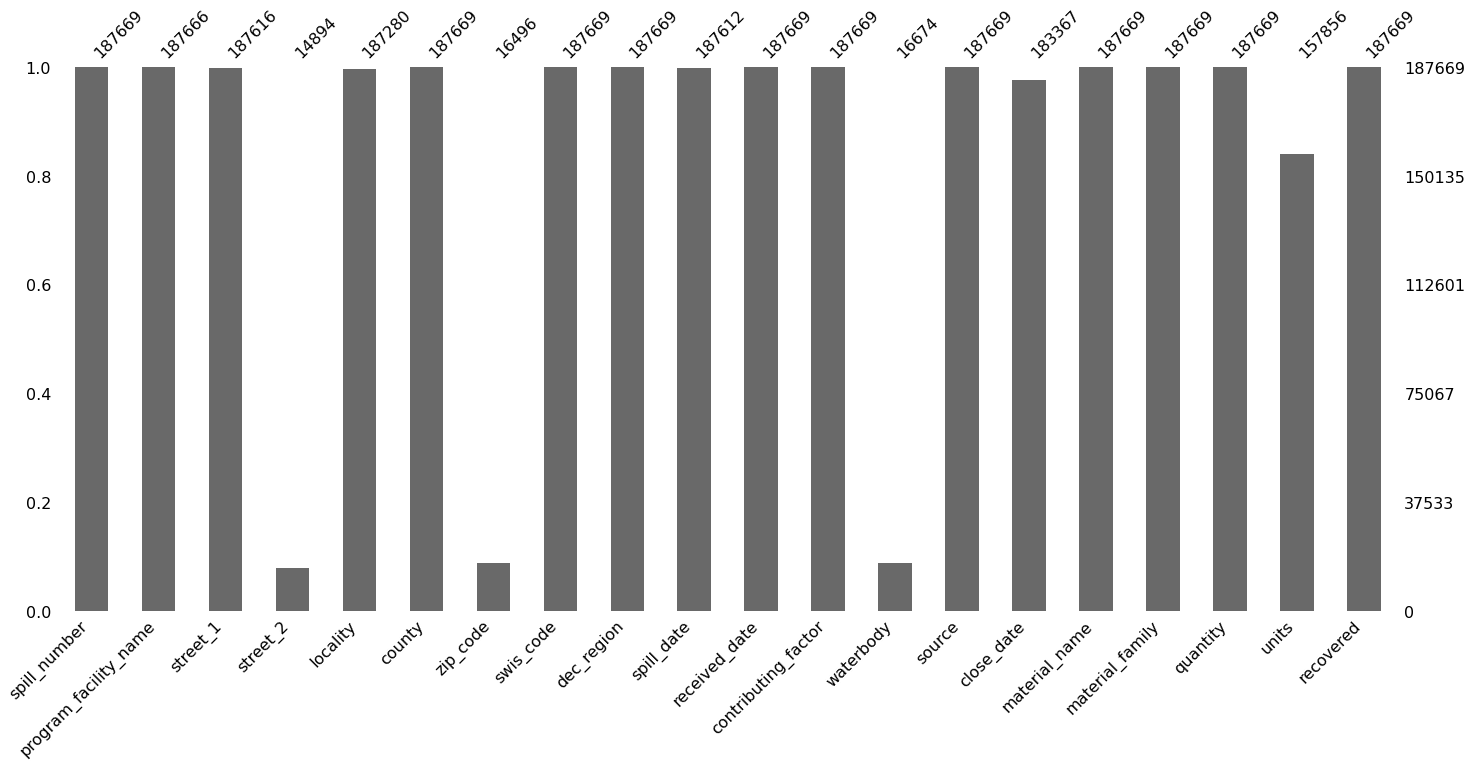

In [27]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

# Plot amount of missingness
msno.bar(data)